In [ ]:
!pip install rdkit kaggle

In [ ]:
!pip install rdkit --upgrade

In [ ]:
!pip install pyvis

In [3]:
import time
import sys
import numpy      as np
import pandas     as pd
import matplotlib.pyplot as plt
import seaborn    as sns
import networkx   as nx  # For creating and manipulating graph structures

from   zipfile    import ZipFile
from   datetime   import datetime
from collections import Counter
import random
import re
import psutil
import copy
import json
import os

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdmolops
from tqdm       import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Subset
from torch.optim import lr_scheduler
from torch.distributions import Normal

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics         import accuracy_score, mean_absolute_error, r2_score
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.decomposition   import TruncatedSVD
from sklearn.model_selection import KFold

In [4]:
api_token = {"username":"alji1305","key":"4703b0a6c6a8543e51a6de4131ab05cb"}

with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

with open('kaggle.json', 'r') as file:
    kaggle_credentials = json.load(file)

username = kaggle_credentials['username']
api_key  = kaggle_credentials['key']


os.environ['KAGGLE_USERNAME'] = username
os.environ['KAGGLE_KEY']      = api_key

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d basu369victor/zinc250k

In [6]:
with ZipFile('zinc250k.zip') as zp:
    zinc_data = pd.read_csv(zp.open('250k_rndm_zinc_drugs_clean_3.csv'))

adjusted_smiles  = []
for index, smile in enumerate(zinc_data['smiles']):
  smile          = smile.replace('\n', '')
  adjusted_smiles.append(smile)

zinc_data['smiles'] = adjusted_smiles

**Data Details**
1. ssr contains list of lists with indexes that correspond to rings
2. Atoms contains the symbol of the atom corresponding to index
3. Bonds contains tuples of bonded indexes

**Algorithm for Junction Tree**
1. Simple version has been solved, not investigating nuances in chemical structures
2. Next step: max each node to a dictionary index value representing different molecules, rings, etc.
3. Will need to add a check for aromatic molecules so that can be added to chemical vocabulary
4. Will need to get bond types (double, triple) etc to correctly create vocabulary
5. Consider other chemical structure occurences that would ened to be considered to create a chemical dictionary of the nodes in each of our molecules
6. Last step is to map the values in adjency matrix to their true value (1 --> 103 example)

In [62]:
def metadata_smiles(bonds, mol, smile, atoms_dict):
  # Identify aromatic rings and bond types
  atoms             = mol.GetAtoms()
  bonds             = mol.GetBonds()

  aromatic_atoms    = [atom.GetIdx() for atom in atoms if atom.GetIsAromatic()]
  double_bonds      = [bond.GetIdx() for bond in bonds if bond.GetBondType() == Chem.rdchem.BondType.DOUBLE]
  triple_bonds      = [bond.GetIdx() for bond in bonds if bond.GetBondType() == Chem.rdchem.BondType.TRIPLE]

  double_list       = []
  for bond in double_bonds:
    bond_object       = bonds[bond]
    double_bond_atoms = tuple(sorted((bond_object.GetBeginAtomIdx(), bond_object.GetEndAtomIdx())))
    double_list.append(double_bond_atoms)

  triple_list       = []
  for bond in triple_bonds:
    bond_object       = bonds[bond]
    triple_bond_atoms = tuple(sorted((bond_object.GetBeginAtomIdx(), bond_object.GetEndAtomIdx())))
    triple_list.append(triple_bond_atoms)


  bonded_atoms      = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in bonds]
  # Identify functional groups (as an example, using alcohols)
  # alcohol_groups = mol.GetSubstructMatches(Chem.MolFromSmarts('CO'))

  # Identify chiral centers
  chiral_centers    = Chem.FindMolChiralCenters(mol, includeUnassigned=True)

  # Assemble the information
  molecule_info     = {
      "atoms":  atoms_dict,
      'bonds':  bonded_atoms,
      "Aromatic_Atoms": aromatic_atoms,
      "Double_Bonds":   double_list,
      "Triple_Bonds":   triple_list,
      "Chiral_Centers": chiral_centers,
  }


  return molecule_info


In [63]:
def smiles_to_matrix(zinc_data):

  v1                   = {}
  v2_ring              = {}
  adjacency_matricies  = []
  atom_dict            = {}
  molecule_df          = {}
  max_spanning_trees   = []
  for i, smile in tqdm(enumerate(zinc_data['smiles']), total = len(zinc_data)):
    molecule       = Chem.MolFromSmiles(smile)
    atoms          = [atom.GetSymbol() for atom in molecule.GetAtoms()]

    # Store original atom indexes in dictionary for later to create molecule tokens
    atom_dict      = {index: atom for index, atom in enumerate(atoms)}
    bonds          = [tuple(sorted((bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()))) for bond in molecule.GetBonds()]
    ssr            = [list(x) for x in Chem.GetSymmSSSR(molecule)]  # GetSymmSSSR finds smallest set of smallest rings
    v2             = set()
    non_ring_bonds = set(sorted(bonds))
    molecule_info  = metadata_smiles(bonds, molecule, smile, atom_dict)
    molecule_df[i] = molecule_info

    # Iterate Through Rings
    for ring in ssr:
      temp_atoms = copy.copy(atoms)

      for index in range(len(ring)):
        begin_atom_idx = ring[index]
        end_atom_idx   = ring[(index + 1) % len(ring)]  # To loop back to the start
        bond           = molecule.GetBondBetweenAtoms(begin_atom_idx, end_atom_idx)

        if bond is not None:
            bond_idx_tuple = tuple(sorted((begin_atom_idx, end_atom_idx)))
            v2.add(bond_idx_tuple)

      # v2
      non_ring_bonds = set(sorted(non_ring_bonds)) - set(sorted(v2))

      subset_dict        = [atoms, v2, non_ring_bonds]
      v1[i]              = non_ring_bonds

      # Stores all V2 rings after some post processing
      v2_ring[i]         = ssr

    # Step 2: Merge Bridged Rings
    # Example of Bridged Ring: Bicyclo[2.2.2]octane
    if len(ssr) > 0:
      v2_copy     = copy.deepcopy(v2_ring[i])
    # If no rings, all bonds are the bonds calculated initially
    else:
      v1[i]       = bonds

    counter = 0
    for r1 in v2_copy:
        for r2 in v2_copy:
            # Don't evaluate identical rings and fit algorithm criteria
            if r1 != r2 and len(set(r1).intersection(r2)) > 2:
                # Merge r1 and r2
                counter += 1
                new_ring       = r1 + r2
                v2_ring[i]     = [ring for ring in v2_ring[i] if ring not in [r1, r2]]
                v2_ring[i].append(new_ring)

    # Step 3: Find Intersection Atoms (V0)
    # V0 ← atoms being the intersection of three or more clusters in V1 ∪ V2
    # Property that finds tertiary carbons/ any other tertiary molecules (Mostly Carbons)
    all_clusters = list(v1[i]) + list(v2)
    atoms        = [atom for cluster in all_clusters for atom in cluster]
    atom_counts  = Counter(atoms)
    v0           = {atom for atom, count in atom_counts.items() if count >= 3}

    # The set of all nodes (V)
    V              = set().union(v1[i])
    if len(ssr) > 0:
      v2_ring[i]   = set([tuple(sub_list) for sub_list in v2_ring[i]])
      V            = V.union([ring for ring in v2_ring[i]])
    V              = V.union(v0)  # Add all atoms from v0


    # Add nodes for each cluster (ring or bond)
    junction_tree = nx.Graph()
    for cluster in V:
        junction_tree.add_node(cluster)

    # Add edges between clusters that share junction atoms
    # Finds the shared atoms for Nodes
    for cluster1 in junction_tree.nodes():
        for cluster2 in junction_tree.nodes():
            if cluster1 != cluster2:

                # Different combinations of Tertiary, single atoms, and ring bonds
                shared_atoms = None
                if isinstance(cluster1, int) and isinstance(cluster2, int):
                  shared_atoms = set([cluster1]).intersection(set([cluster2]))
                elif isinstance(cluster2, int):
                    if cluster2 in cluster1:  # If the single atom is in the cluster
                        shared_atoms = set([cluster2])
                elif isinstance(cluster1, int):
                    if cluster1 in cluster2:  # If the single atom is in the cluster
                        shared_atoms = set([cluster1])
                else:
                  shared_atoms = set(cluster1).intersection(set(cluster2))


                if shared_atoms is not None and len(shared_atoms) > 0:
                  contains_index = any(list(shared_atoms) in tup for tup in list(v1[i]))
                  # Conditions to check for consecutive v1 bonds... (1,2) should be connected to (2, 4)
                  v1_bonds       = True in [list(shared_atoms)[0] in tup for tup in list(v1[i])]


                if shared_atoms and (shared_atoms.issubset(v0) or v1_bonds):
                    junction_tree.add_edge(cluster1, cluster2, weight=len(shared_atoms))

    # Now junction_tree is your junction graph representing the molecule

    # Step 5: Find Maximum Spanning Tree
    mst = nx.maximum_spanning_tree(junction_tree)

    # Get the adjacency matrix representing connections
    adj_matrix             = nx.adjacency_matrix(mst)
    adj_matrix             = adj_matrix.todense()

    adjacency_matricies.append(adj_matrix)
    max_spanning_trees.append(mst)

    if i > 10000:
      break

  return adjacency_matricies, molecule_df, max_spanning_trees

adjacency_matricies, molecule_df, junction_tree = smiles_to_matrix(zinc_data)

  4%|▍         | 10001/249455 [00:46<18:21, 217.32it/s]


**Uniquely Identifying Substructures**
1. Rings are their own "words"
2. Aromaticity, atoms in ring, # of atoms are needed to identify
3. Chirality is likely important
4. Current Nodes in MST Represent candidates for vocabulary
5. Double and triple bonds can be found by the index in bonds sub dictionary and then calliung atoms dictionary

In [ ]:
molecule_df[0]

In [77]:
def construct_vocabulary(adjacency_matricies, molecule_df, junction_tree):
  '''
  Construct Vocabulary for the adjacency matrix, molecule_df, and junction tree
  ------------------------------------------------------------------
  ------------------------------------------------------------------
  Parameters:
    adjacency_matricies:
    molecule_df:
    junction_tree:

  '''
  counter             = 0
  smiles_keys         = list(molecule_df[0].keys())[1:]
  molecule_dictionary = {}
  vocabulary          = {}
  molecule_index      = 1

  # Could clean up all the code by writing a function that takes a category such as "aromatic_atoms"
  for index in range(len(junction_tree)):
    vocabulary[index]    = {}
    nodes                = junction_tree[index].nodes
    molecule_data        = molecule_df[index]
    converted            = None

    for descriptor in smiles_keys:
      ring_count         = 1
      bond_count         = 1
      dbl_bond_count     = 1
      trp_bond_count     = 1


      for node in nodes:
        # Need to fix this to find elements beter 05 Feb 2024
        # Tuple can either be a pair of bonds (single, double, or triple) or ring
        if isinstance(node, tuple):
          conversions    = []
          node_len       = len(node)

          if node_len > 2 and descriptor == 'Aromatic_Atoms':
            vocabulary[index][descriptor + ' ' + str(ring_count)] = []
            for sub_node in node:
              converted  = molecule_data['atoms'][sub_node]
              conversions.append((sub_node, converted))

            if index == 3340:
              print(conversions, node)

            vocabulary[index][descriptor + ' ' + str(ring_count)].append(conversions)
            ring_count  += 1

          # Adding double bonds to vocabulary
          if descriptor == 'Double_Bonds':
            atoms       = molecule_data[descriptor]
            # Atoms can contain a list of tuples representing double bonds
            for atom_sets in atoms:
              if atom_sets == node:
                vocabulary[index][descriptor + ' ' + str(dbl_bond_count)] = []
                for ind_atom in atom_sets:
                  converted = molecule_data['atoms'][ind_atom]
                  conversions.append((ind_atom, converted))

                vocabulary[index][descriptor + ' ' + str(dbl_bond_count)].append(conversions)
                dbl_bond_count += 1

          # Adding triple bonds to vocabulary
          if descriptor == 'Triple_Bonds':

              atoms     = molecule_data[descriptor]
              for atom_sets in atoms:
                if atom_sets == node:
                  vocabulary[index][descriptor + ' ' + str(trp_bond_count)] = []
                  for ind_atom in atom_sets:
                    converted = molecule_data['atoms'][ind_atom]
                    conversions.append((ind_atom, converted))

                  vocabulary[index][descriptor + ' ' + str(trp_bond_count)].append(conversions)
                  trp_bond_count += 1

          # Adding Single bonded atoms if they are a node in Junction Tree
          if descriptor == 'bonds':
            atoms     = molecule_data[descriptor]
            for atom_sets in atoms:
              if len(atom_sets) == 2:
                reverse_atoms = (atom_sets[1], atom_sets[0])
              else:
                reverse_atoms = None

              if atom_sets == node or reverse_atoms == node:
                vocabulary[index][descriptor + ' ' + str(bond_count)] = []
                for ind_atom in atom_sets:
                  converted = molecule_data['atoms'][ind_atom]
                  conversions.append((ind_atom, converted))

                vocabulary[index][descriptor + ' ' + str(bond_count)].append(conversions)
                bond_count += 1

        else:
            if descriptor == 'Chiral_Centers':
              converted    = molecule_data['atoms'][node]
              sub_category = molecule_data[descriptor]
              # print(sub_category, converted)

              for chiral_molecule in sub_category:
                if chiral_molecule[0] == node:
                  vocabulary[index][descriptor + ' ' + str(molecule_index)] = []
                  # Create a running dictionary

                  if converted not in molecule_dictionary:
                    molecule_dictionary[converted] = molecule_index

                  vocabulary[index][descriptor + ' ' + str(molecule_index)].append((node, str(converted) + f'({chiral_molecule[1]})'))
                  molecule_index += 1

  return vocabulary, molecule_dictionary

vocabulary, molecule_dictionary = construct_vocabulary(adjacency_matricies, molecule_df, junction_tree)

[(4, 'C'), (26, 'C'), (25, 'C'), (7, 'C'), (6, 'C'), (5, 'C')] (4, 26, 25, 7, 6, 5)
[(14, 'C'), (15, 'C'), (17, 'C'), (18, 'N'), (19, 'C'), (13, 'C'), (12, 'C'), (13, 'C'), (14, 'C'), (15, 'C'), (16, 'C'), (11, 'N')] (14, 15, 17, 18, 19, 13, 12, 13, 14, 15, 16, 11)
[(12, 'C'), (13, 'C'), (14, 'C'), (15, 'C'), (16, 'C'), (11, 'N'), (14, 'C'), (15, 'C'), (17, 'C'), (18, 'N'), (19, 'C'), (13, 'C')] (12, 13, 14, 15, 16, 11, 14, 15, 17, 18, 19, 13)
[(20, 'C'), (21, 'C'), (22, 'C'), (23, 'C'), (18, 'N'), (19, 'C')] (20, 21, 22, 23, 18, 19)


In [43]:
def build_unique_vocabulary(vocabulary, zinc_data):
  '''
  Goal of this function is to assign unique "words" to every molecular structure previously identified

  Parameters:
    vocabulary:

  Returns:
    token_dictionary: index representations of the original chemical structure
    unique_vocab: the dictionary containing the identified unique chemical vocabulary

  '''

  token_dictionary         = {}
  unique_vocab             = {}
  vocab_counter            = 0

  for index in vocabulary:
    smiles_rep             = zinc_data['smiles']
    token_representations  = []

    for category in vocabulary[index]:
      aromatic_counter     = 0
      atoms                = ''
      category_items       = vocabulary[index][category][0]



      if isinstance(category_items, list):
        if index == 3340:
          print(category_items)
        for item in category_items:
            aromatic_counter += 1
            atoms            += item[1]



        # Unique way to identify double bonds
        if 'Double_Bonds' in category:
          atoms += ' dbl'

        # Unique_way to identify triple bonds
        elif 'Triple_Bonds' in category:
          atoms += ' tpl'

      # Need to go back and make sure tertiary and quaternary atoms are represented different
      else:
        atoms   += category_items[1] + ' tert or quat'

      if atoms not in unique_vocab:
          unique_vocab[atoms] = vocab_counter
          vocabulary_token    = unique_vocab[atoms]
          vocab_counter      += 1
      else:
          vocabulary_token    = unique_vocab[atoms]



      token_representations.append(vocabulary_token)

    if index == 3340:
        print(token_representations, vocabulary_token)
        # print(token_dictionary[3])
    token_dictionary[index] = token_representations
  return token_dictionary, unique_vocab


token_dictionary, unique_vocab = build_unique_vocabulary(vocabulary, zinc_data)


[(0, 'C'), (1, 'O')]
[(9, 'C'), (10, 'S')]
[(2, 'C'), (4, 'C')]
[(1, 'O'), (2, 'C')]
[(8, 'N'), (9, 'C')]
[(9, 'C'), (11, 'N')]
[(2, 'C'), (3, 'O')]
[(23, 'C'), (24, 'O')]
[(7, 'C'), (8, 'N')]
[(4, 'C'), (26, 'C'), (25, 'C'), (7, 'C'), (6, 'C'), (5, 'C')]
[(14, 'C'), (15, 'C'), (17, 'C'), (18, 'N'), (19, 'C'), (13, 'C'), (12, 'C'), (13, 'C'), (14, 'C'), (15, 'C'), (16, 'C'), (11, 'N')]
[(12, 'C'), (13, 'C'), (14, 'C'), (15, 'C'), (16, 'C'), (11, 'N'), (14, 'C'), (15, 'C'), (17, 'C'), (18, 'N'), (19, 'C'), (13, 'C')]
[(20, 'C'), (21, 'C'), (22, 'C'), (23, 'C'), (18, 'N'), (19, 'C')]
[(9, 'C'), (10, 'S')]
[(2, 'C'), (3, 'O')]
[(23, 'C'), (24, 'O')]
[1, 18, 0, 11, 4, 2, 1, 1, 2, 5, 267, 268, 21, 42, 7, 7, 10, 14] 14


**Left Off here 10 Feb 2024**
1. Need to encode rings correctly in the ring vocab (rings are being joined how I have the code)
2. Need to identify a way to check if similar strings I extract are equivalent molecular structures --> SMILES may be able to help, but will have to extract rings from zinc_data['smiles']

[4, 26, 25, 7, 6, 5]
[12, 13, 14, 15, 16, 11]
[14, 15, 17, 18, 19, 13]
[20, 21, 22, 23, 18, 19]


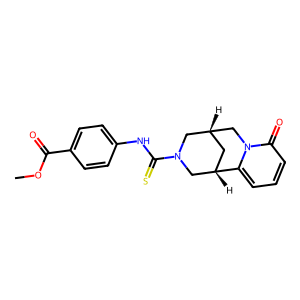

In [68]:
from rdkit.Chem import Draw

# Convert the SMILES string to an RDKit molecule object
molecule = Chem.MolFromSmiles(zinc_data['smiles'][3340])
[print(list(atom)) for atom in Chem.GetSymmSSSR(molecule)]
# Draw the moleculex


Draw.MolToImage(molecule)

In [75]:
zinc_data['smiles'][3340]

'COC(=O)c1ccc(NC(=S)N2C[C@@H]3C[C@H](C2)Cn2c3cccc2=O)cc1'

In [ ]:
token_dictionary[3340]

In [35]:
for index in token_dictionary:
  try:
    index_found = token_dictionary[index].index(267)
    print(index)
  except ValueError:
    pass

3340
7833


In [13]:
print("Nodes:", junction_tree[0].nodes(data=True))
print("Edges:", junction_tree[0].edges(data=True))

Nodes: [((0, 1), {}), (1, {}), ((1, 2), {}), ((10, 11), {}), (4, {}), (7, {}), (10, {}), ((12, 13), {}), (12, {}), (15, {}), ((16, 17, 18, 19, 20, 15), {}), (20, {}), (22, {}), ((1, 3), {}), ((12, 14), {}), ((20, 21), {}), ((1, 4), {}), ((11, 12), {}), ((4, 23, 22, 7, 6, 5), {}), ((14, 15), {}), ((8, 7, 22, 10, 9), {})]
Edges: [((0, 1), 1, {'weight': 1}), ((0, 1), (1, 2), {'weight': 1}), ((0, 1), (1, 3), {'weight': 1}), ((0, 1), (1, 4), {'weight': 1}), ((10, 11), 10, {'weight': 1}), ((10, 11), (11, 12), {'weight': 1}), ((10, 11), (8, 7, 22, 10, 9), {'weight': 1}), (4, (1, 4), {'weight': 1}), (4, (4, 23, 22, 7, 6, 5), {'weight': 1}), (7, (4, 23, 22, 7, 6, 5), {'weight': 1}), ((12, 13), 12, {'weight': 1}), ((12, 13), (12, 14), {'weight': 1}), ((12, 13), (11, 12), {'weight': 1}), (15, (16, 17, 18, 19, 20, 15), {'weight': 1}), (15, (14, 15), {'weight': 1}), ((16, 17, 18, 19, 20, 15), 20, {'weight': 1}), ((16, 17, 18, 19, 20, 15), (20, 21), {'weight': 1}), (22, (4, 23, 22, 7, 6, 5), {'weigh


**Question 01 Feb 2024**
1. WHat do the individual nodes represent vs the center nodes and why are they not connectd to the center
2. as it stands, singular atoms are not being joined to bonds in the strucutre. Look at print statement above to see what i mean future me!

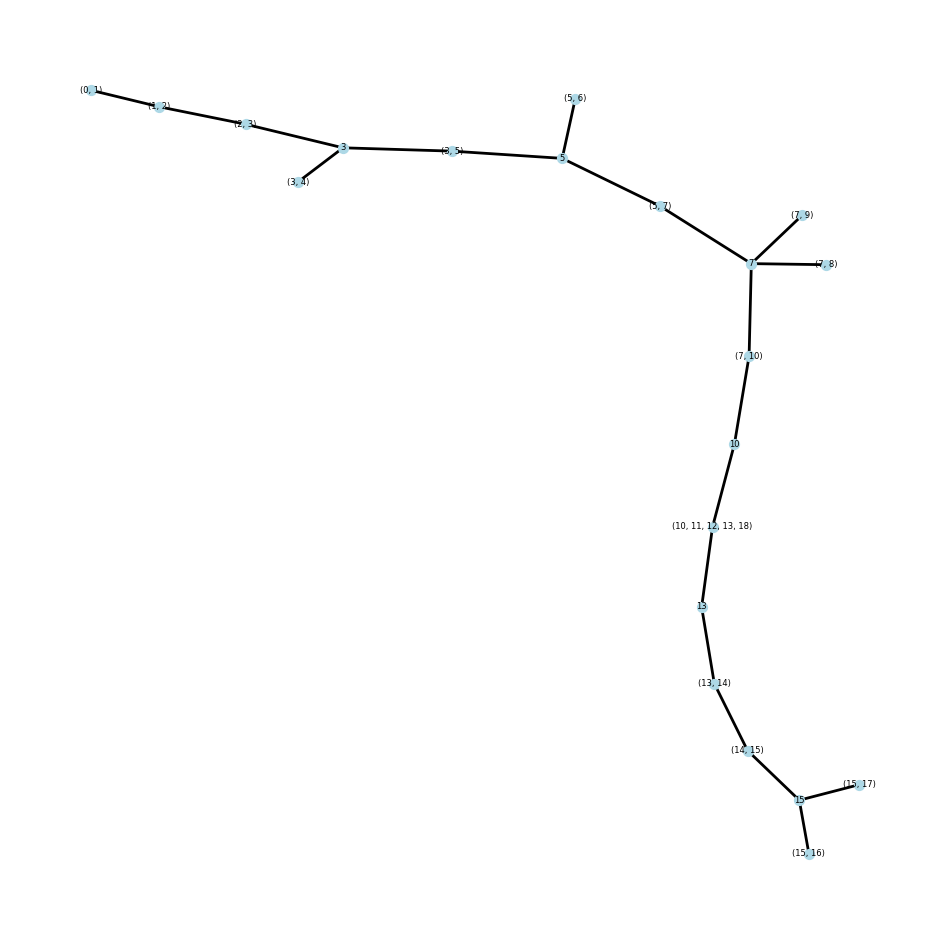

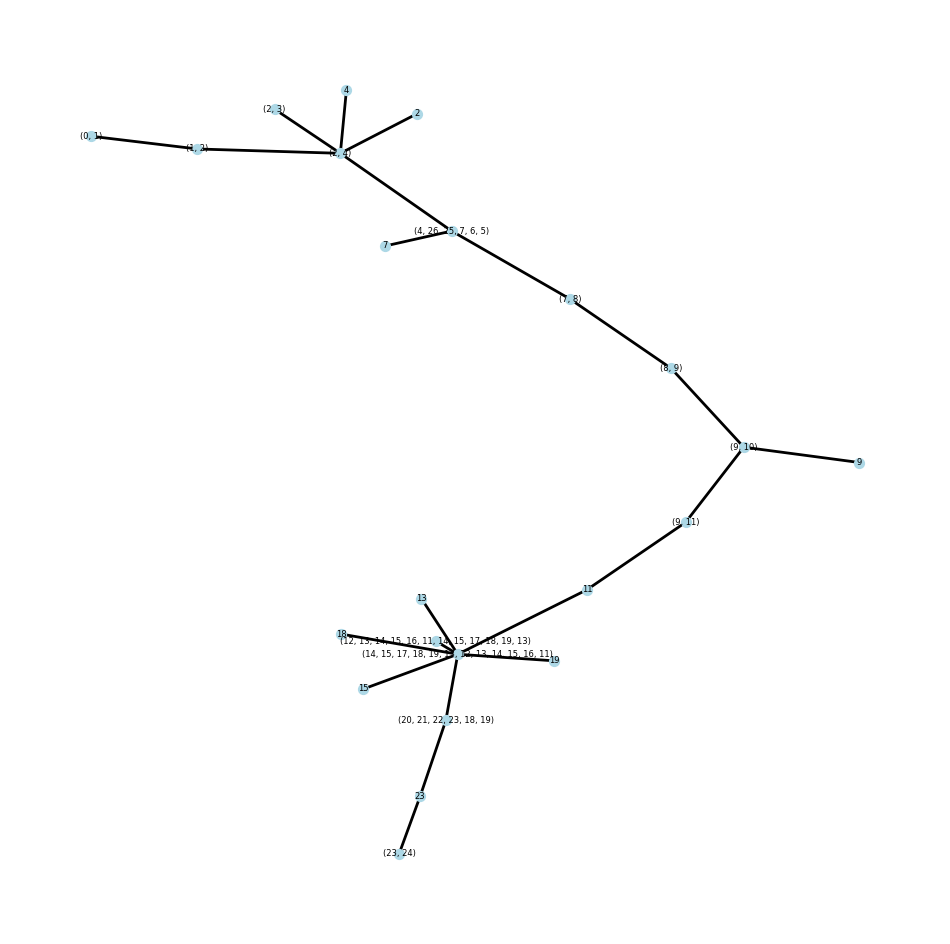

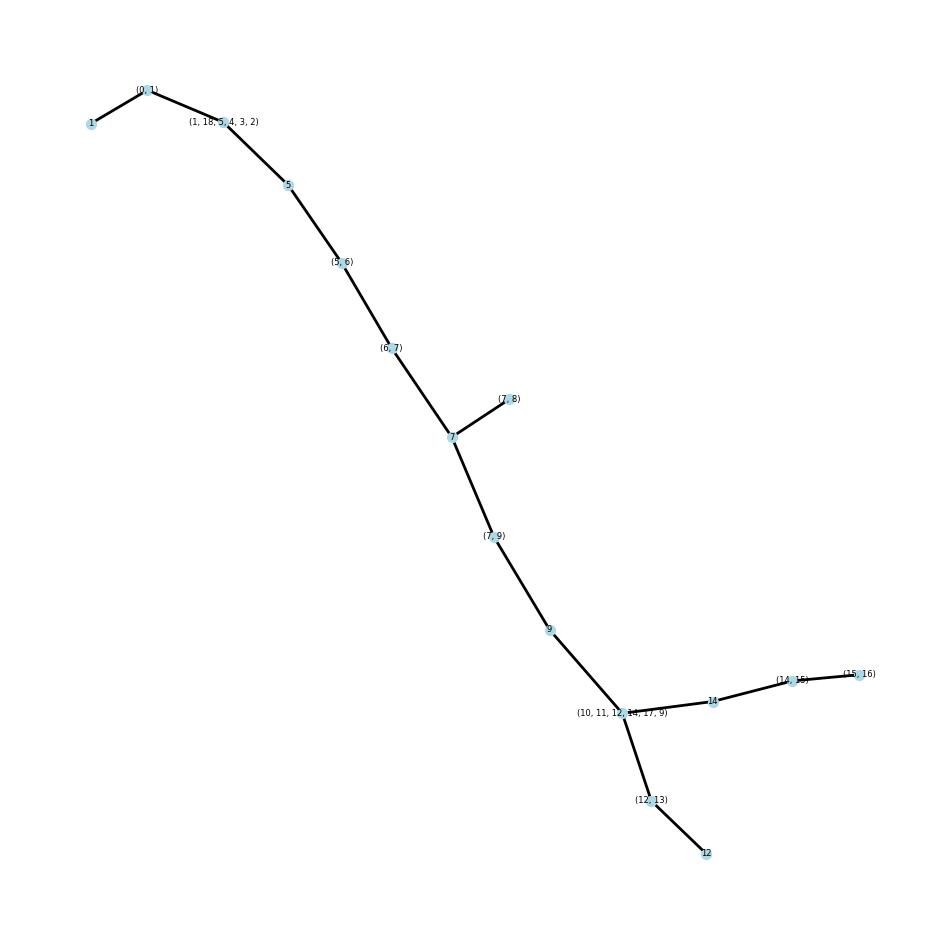

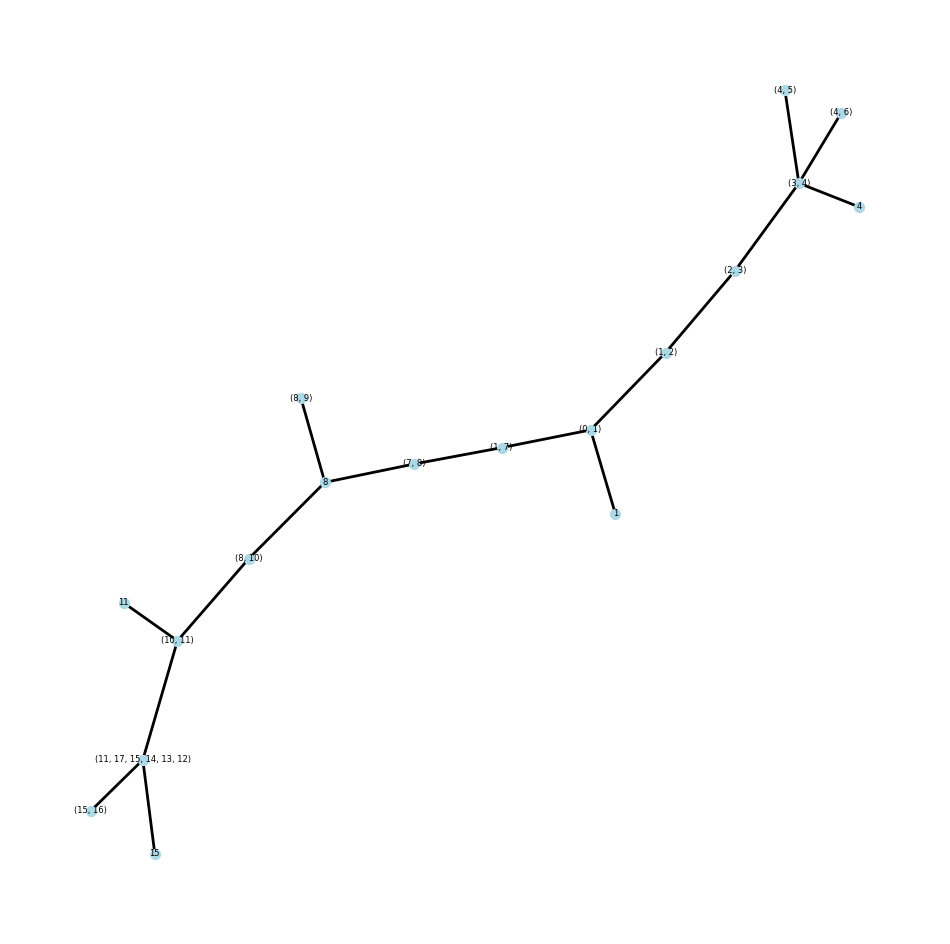

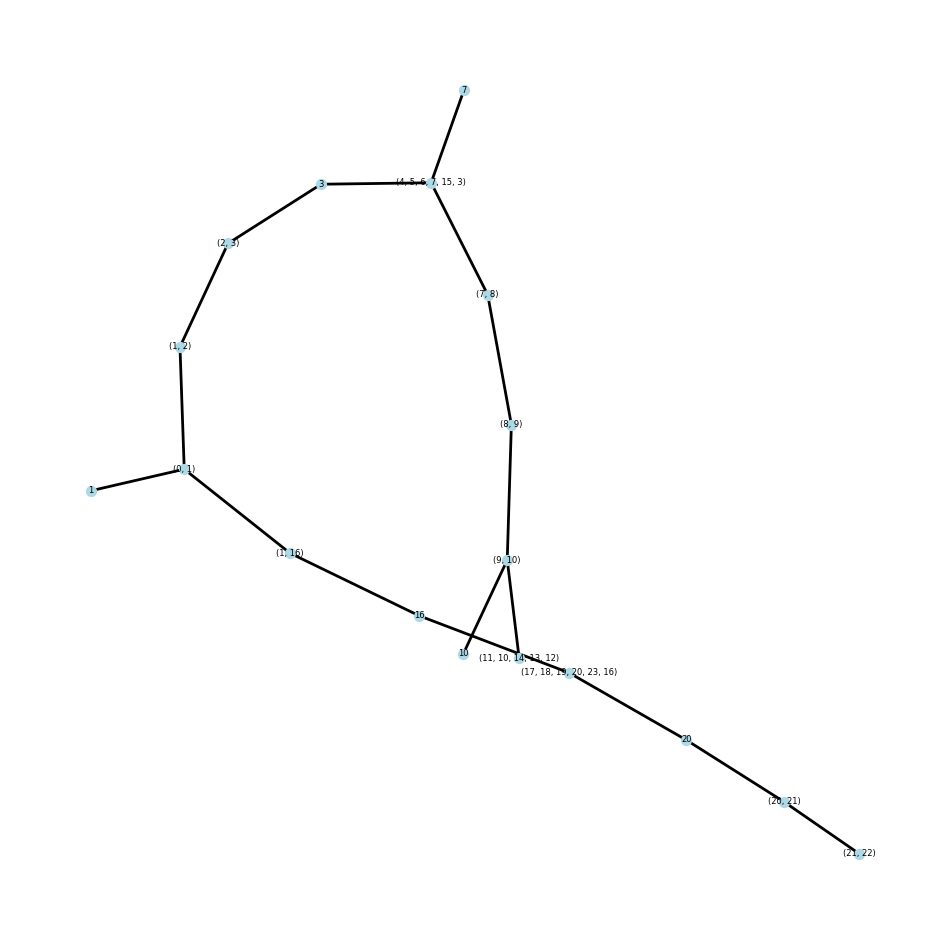

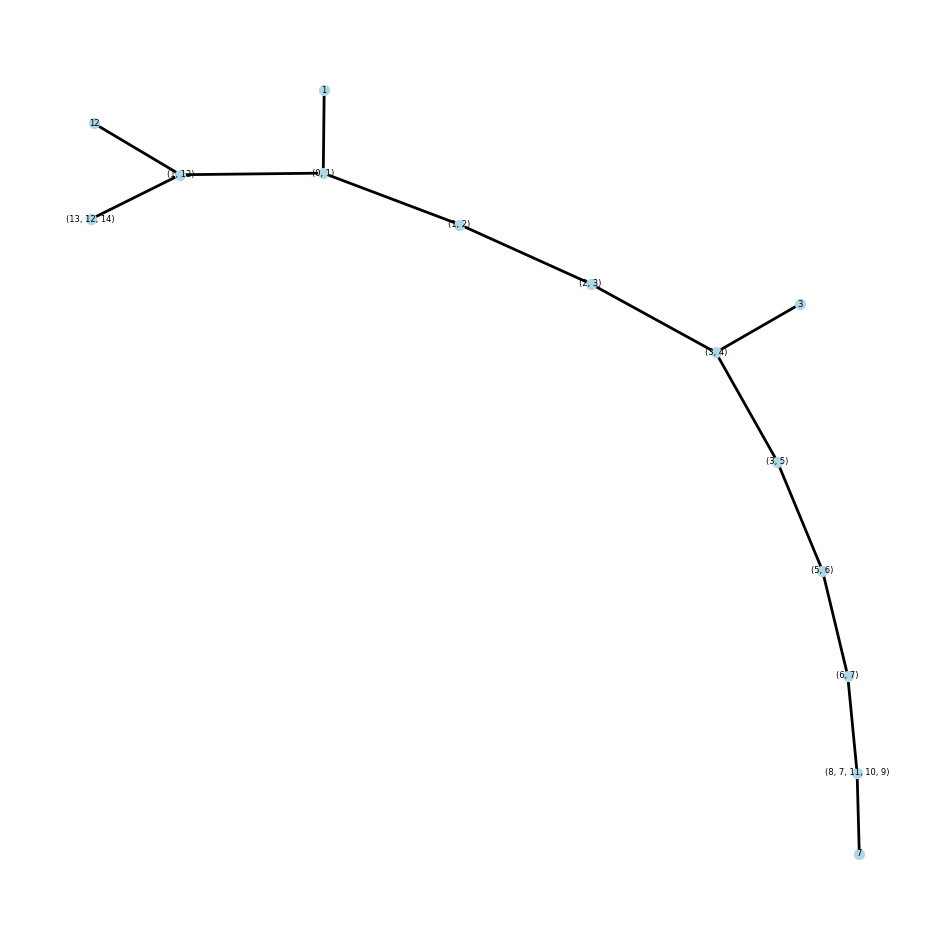

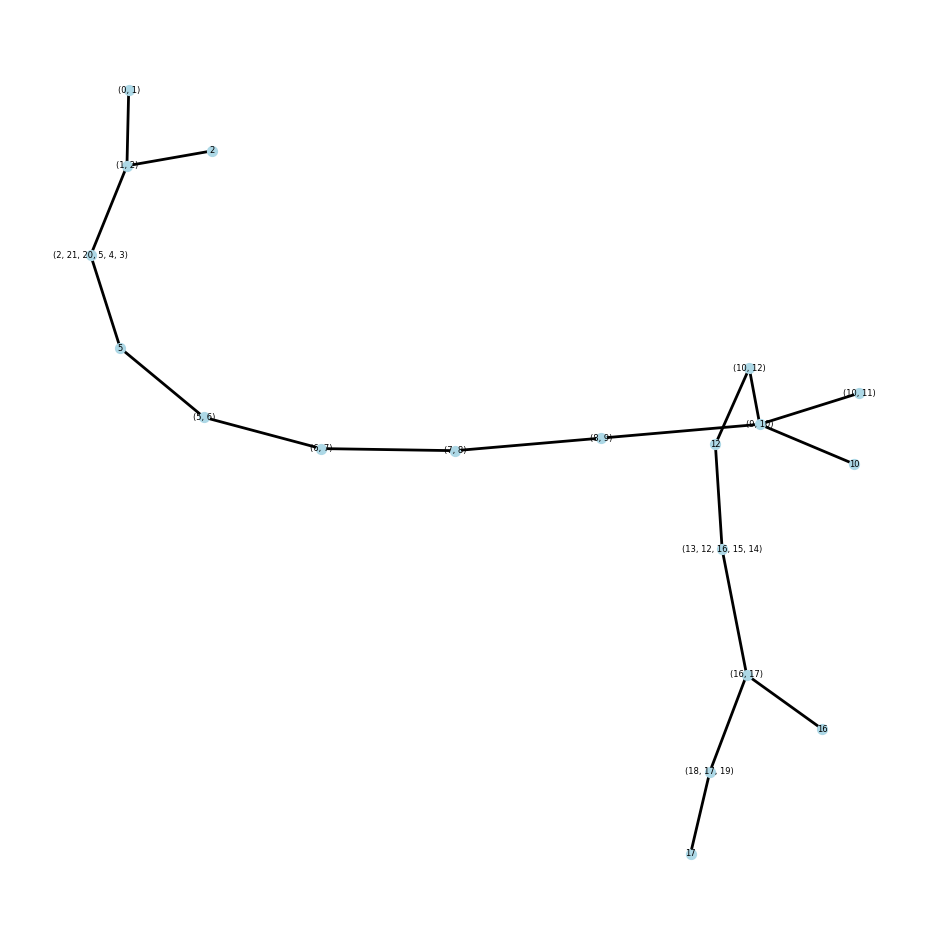

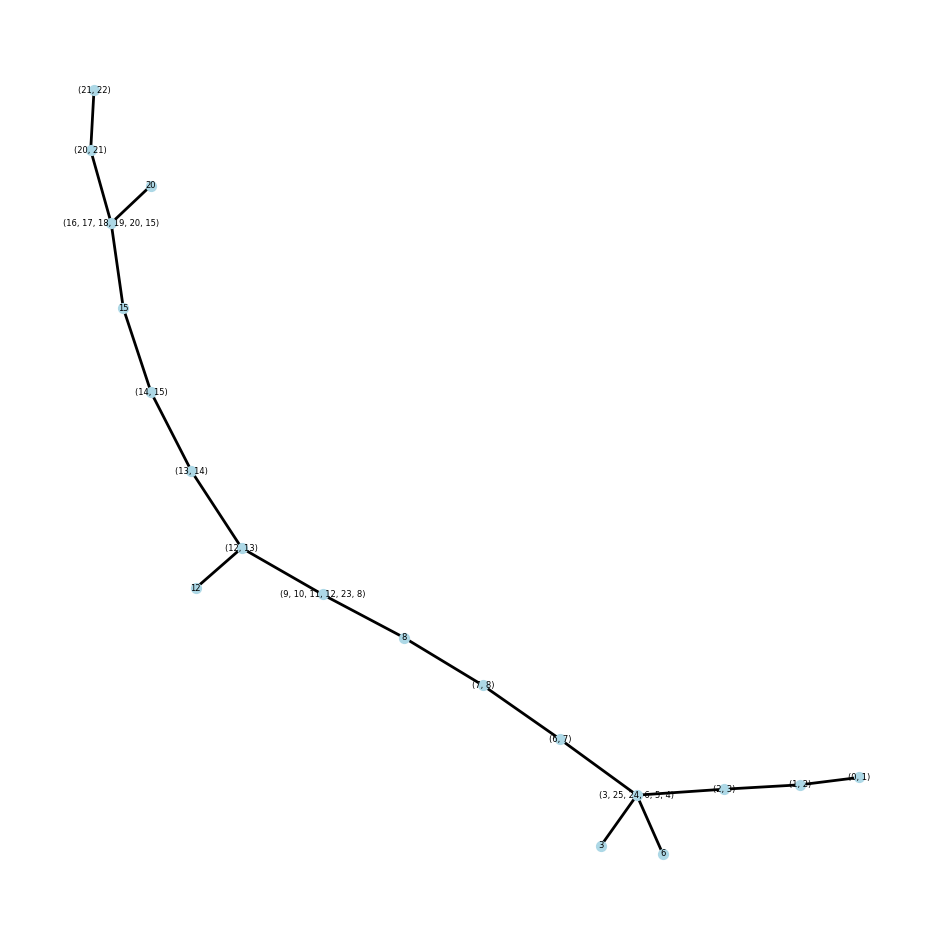

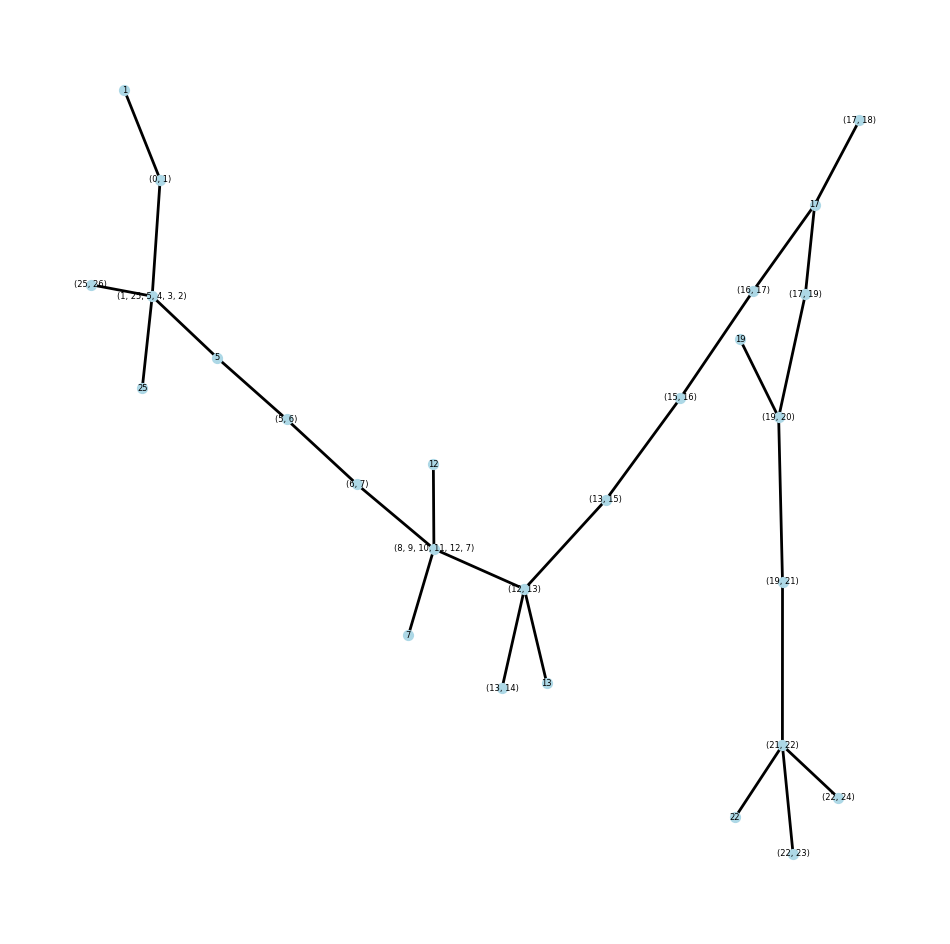

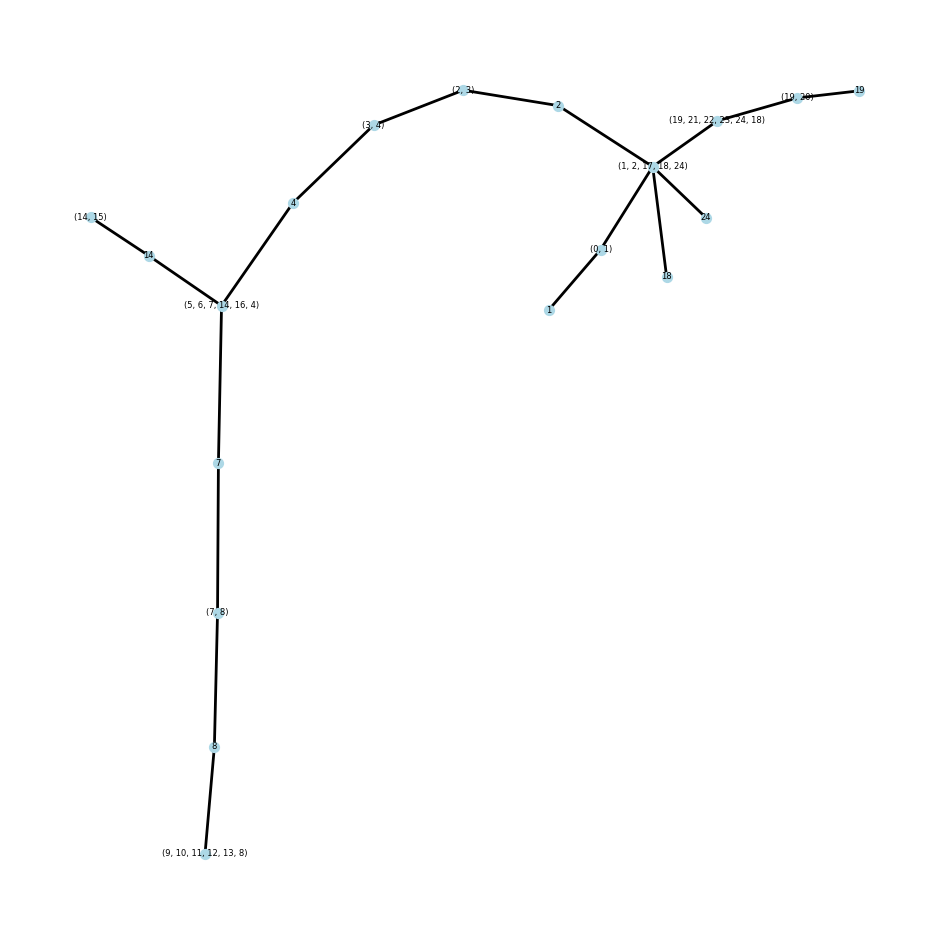

In [49]:
def plot_junction_tree(junction_tree, random_var = False, n_trees = 10, start_index = 0):
  # Draw the graph
  def plot(tree):
      plt.figure(figsize=(12, 12))  # Set the size of the plot
      pos = nx.spring_layout(tree)  # Positions for all nodes

      # Nodes
      nx.draw_networkx_nodes(tree, pos, node_size=50, node_color="lightblue")

      # Edges
      nx.draw_networkx_edges(tree, pos, width=2)

      # Labels
      nx.draw_networkx_labels(tree, pos, font_size=6, font_family="sans-serif")

      # Show the plot
      plt.axis("off")  # Turn off the axis
      plt.show()

  if not random_var:
     for tree in junction_tree[start_index:start_index + n_trees]:
      plot(tree)

  elif isinstance(junction_tree, list) and random_var:
    trees   = [random.randint(0, len(junction_tree)) for _ in range(n_trees)]
    for tree in junction_tree[:n_trees]:
      plot(tree)

plot_junction_tree(junction_tree, random_var = False, start_index = 3339)


**Algorithm 2**

 Tree decomposition of molecule G = (V, E)
1. V1 ← the set of bonds (u, v) ∈ E that do not belong to any rings.
2. V2 ← the set of simple rings of G.
forr1,r2 inV2 do
Merge rings r1 , r2 into one ring if they share more than two atoms (bridged rings). end for
V0 ← atoms being the intersection of three or more clusters in V1 ∪ V2.
V ← V0 ∪ V1 ∪ V2
E ← {(i, j, c) ∈ V × V × R | |i ∩ j| > 0}. Set c = ∞ if i ∈ V0 or j ∈ V0, and c = 1 otherwise. Return The maximum spanning tree over cluster graph (V , E ).